# 实践: 基于AlexNet的裂缝图像分类

## 0 基础设置

### 0.1 导入需要的模块

In [1]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torch.utils import data
from cv2 import imread
import torch.nn.functional as F

In [24]:
from torch.optim.lr_scheduler import StepLR

需要在当前环境下安装 tqdm cv2 等包
```bash
pip install tqdm

pip install opencv-python
```

### 0.2 显示与绘图设置

In [2]:
# 解决中文显示问题
# 运行配置参数中的字体（font）为黑体（SimHei）
plt.rcParams['font.sans-serif'] = ['simHei']
# 运行配置参数总的轴（axes）正常显示正负号（minus）
plt.rcParams['axes.unicode_minus'] = False

## 1 数据预处理

In [3]:
# 将图像的像素值归一化到[-1,1]之间
#三个通道的均值和标准差都为0.5
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

# Compose(): 将多个transforms的操作整合在一起
# 输入为224*224  但是训练数据如果不是这个值，那就resize到224*224
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])

val_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])

## 2 数据的组织

### 2.1 创建 Dataset

In [4]:
class crackInfo:
    # 定义包含数据集信息的类 crackInfo
    rootdir = 'dataset'  # 数据集的根目录
    names = [
        'Crack',  # 定义类别名称，裂缝
        'Background',  # 背景
    ]
    labels = [
        'CK',  # 裂缝类别的标签
        'BG',  # 背景类别的标签
    ]

In [5]:
class ClassifyDataset(data.Dataset):
    # 自定义 PyTorch 数据集类，继承自 torch.utils.data.Dataset
    def __init__(self, transform, labelinfo, mode):
        """
        初始化函数
        :param transform: torch.transform, 数据预处理方法
        :param labelinfo: crackInfo, 包含标签与命名信息的类
        :param mode: str, 数据集模式，可以选择 'train' 或 'test'
        """
        self.names = labelinfo.names  # 从 labelinfo 获取类别名称
        self.labels = labelinfo.labels  # 从 labelinfo 获取类别标签
        index = [i for i in range(len(self.names))]  # 创建一个索引列表，用于标识类别
        self.label_name = zip(self.names, index)  # 将类别名称和索引配对
        self.label_length = len(labelinfo.labels[0])  # 获取标签的长度，用于匹配文件名

        # 根据模式选择对应的数据集路径
        if mode == 'train':
            dir = os.path.join(labelinfo.rootdir, 'train')  # 训练集目录
            self.data_info = self.get_img_info(data_dir=dir)  # 获取训练集的图像信息
        elif mode == 'test':
            dir = os.path.join(labelinfo.rootdir, 'val')  # 验证集目录
            self.data_info = self.get_img_info(data_dir=dir)  # 获取验证集的图像信息
        
        self.transform = transform  # 数据预处理方法

    
    def __getitem__(self, index):
        # 获取数据集中的一项（图像和标签）
        path_img, label = self.data_info[index]  # 获取图像路径和对应的标签
        img = imread(path_img)  # 读取图像，图像的像素范围为 0~255，格式为 BGR
        
        # 如果有预处理方法，则应用预处理
        if self.transform is not None:
            img = self.transform(img)  # 转换图像，如转换为 tensor 并归一化
        
        return img, label  # 返回图像和标签

    def __len__(self):
        # 返回数据集的长度 读了多少个数据
        return len(self.data_info)

    def get_img_info(self, data_dir):
        # 获取数据集中的图像信息，包括图像路径和对应的标签
        data_info = []  # 用于存储图像路径和标签的列表
        img_names = os.listdir(data_dir)  # 获取目录中的所有文件名
        img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))  # 过滤出以 '.jpg' 结尾的文件（图像）

        # 遍历所有图像文件名
        for img_name in img_names:
            path_img = os.path.join(data_dir, img_name)  # 获取图像的完整路径
            lblname = img_name[:self.label_length]  # 从文件名中提取标签名（前几个字符）
            label = self.labels.index(lblname)  # 根据标签名查找对应的标签索引
            data_info.append((path_img, int(label)))  # 将图像路径和标签加入到数据集中
        
        return data_info  # 返回包含图像路径和标签的列表

### 2.2 创建 Dataloader

In [10]:
# 设置批量大小和子进程数
batch_size = 8
num_workers = 0  # 不开启多进程 有时多进程根据电脑情况会报错

In [11]:
# 构建MyDataset实例
info = crackInfo()
train_data = ClassifyDataset(transform=train_transform,labelinfo=info,mode='train')
val_data = ClassifyDataset(transform=val_transform,labelinfo=info,mode='test')

# 创建 Dataloader
train_dataloader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_dataloader = DataLoader(dataset=val_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

num_cls=len(info.names)

In [12]:
train_iter = iter(train_dataloader)
next(train_iter)

[tensor([[[[ 0.4510,  0.4588,  0.4902,  ...,  0.4745,  0.4902,  0.4980],
           [ 0.4510,  0.4510,  0.4824,  ...,  0.4824,  0.4902,  0.4902],
           [ 0.4431,  0.4510,  0.4667,  ...,  0.4902,  0.4902,  0.4980],
           ...,
           [ 0.4039,  0.4275,  0.4431,  ...,  0.5608,  0.5529,  0.5529],
           [ 0.4118,  0.4275,  0.4431,  ...,  0.5451,  0.5451,  0.5451],
           [ 0.4353,  0.4510,  0.4510,  ...,  0.5451,  0.5373,  0.5373]],
 
          [[ 0.5216,  0.5294,  0.5608,  ...,  0.5451,  0.5608,  0.5686],
           [ 0.5216,  0.5216,  0.5529,  ...,  0.5529,  0.5608,  0.5608],
           [ 0.5137,  0.5216,  0.5373,  ...,  0.5608,  0.5608,  0.5686],
           ...,
           [ 0.4510,  0.4745,  0.4902,  ...,  0.6000,  0.5922,  0.5922],
           [ 0.4588,  0.4745,  0.4902,  ...,  0.6000,  0.6000,  0.6000],
           [ 0.4824,  0.4980,  0.4980,  ...,  0.6000,  0.5922,  0.5922]],
 
          [[ 0.5451,  0.5529,  0.5843,  ...,  0.5765,  0.5922,  0.6000],
           [ 

1代表是裂缝 0代表不是裂缝

## 3 实现 AlexNet 网络架构

### 3.1 编写网络结构

In [41]:
# 定义AlexNet网络模型
# MyAlexNet(子类)继承nn.Module(父类)
class MyAlexNet(nn.Module):
    # 子类继承中重新定义Module类的__init__()和forward()函数
    # init(): 进行初始化，申明模型中各层的定义
    def __init__(self):
        # super: 引入父类的初始化方法给子类进行初始化
        super(MyAlexNet, self).__init__()
        # conv1: 输入大小为224*224，输出大小为55*55，输入通道为3，输出为96，卷积核为11，，扩充边缘为2，步长为4
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        # 使用ReLU作为激活函数
        self.ReLU = nn.ReLU()
        # MaxPool2d: 最大池化操作
        # 最大池化层，输入大小为55*55，输出大小为27*27，输入通道为96，输出为96，池化核为3，步长为2
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        """ -------- Your code here -------- """
        # conv2: 输入大小为27*27，输出大小为27*27，输入通道为96，输出为256，卷积核为5，扩充边缘为2，步长为1
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        # maxpool2: 输入大小为27*27，输出大小为13*13，输入通道为256，输出为256，池化核为3，步长为2
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # conv3: 输入大小为13*13，输出大小为13*13，输入通道为256，输出为384，卷积核为3，扩充边缘为1，步长为1
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        # conv4: 输入大小为13*13，输出大小为13*13，输入通道为384，输出为384，卷积核为3，扩充边缘为1，步长为1
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # conv5: 输入大小为13*13，输出大小为13*13，输入通道为384，输出为256，卷积核为3，扩充边缘为1，步长为1
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        # maxpool3: 输入大小为13*13，输出大小为6*6，输入通道为256，输出为256，池化核为3，步长为2
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        """ ------------- end -------------- """
        # Flatten(): 将张量（多维数组）平坦化处理，神经网络中第0维表示的是batch_size，所以Flatten()默认从第二维开始平坦化
        self.flatten = nn.Flatten()
        # 全连接层 Linear（in_features，out_features）
        # fc1: 输入神经元数 6 * 6 * 256，输出神经元数 4096
        self.fc1 = nn.Linear(6 * 6 * 256, 4096)
        """ -------- Your code here -------- """
        # fc2: 输入神经元数 4096，输出神经元数 4096
        self.fc2 = nn.Linear(4096,4096)
        # fc3: 输入神经元数 4096，输出神经元数 1000
        self.fc3 = nn.Linear(4096,1000)
        """ ------------- end -------------- """
        # 输出层
        self.fc4 = nn.Linear(1000, 2)
 
    # forward(): 定义前向传播过程,描述了各层之间的连接关系
    def forward(self, x):
        # conv1 - ReLU - maxpool1
        x = self.ReLU(self.conv1(x))
        x = self.maxpool1(x)
        """ -------- Your code here -------- """
        # conv2 - ReLU
        x = self.ReLU(self.conv2(x))
        # maxpool2
        x = self.maxpool2(x)
        # conv3 - ReLU
        x = self.ReLU(self.conv3(x))
        # conv4 - ReLU
        x = self.ReLU(self.conv4(x))
        # conv5 - ReLU
        x = self.ReLU(self.conv5(x))
        # maxpool3
        x = self.maxpool3(x)
        """ ------------- end -------------- """
        # 展平层
        x = self.flatten(x)
        # 全连接层
        x = self.fc1(x)
        # Dropout: 随机地将输入中50%的神经元激活设为0，即去掉了一些神经节点，防止过拟合
        # “失活的”神经元不再进行前向传播并且不参与反向传播，这个技术减少了复杂的神经元之间的相互影响
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        x = F.dropout(x, p=0.5)
        x = self.fc4(x)
        return x

### 3.2 实例化

In [42]:
# 如果有NVIDA显卡，可以转到GPU训练，否则用CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 模型实例化，将模型转到device
model = MyAlexNet().to(device)

## 4 定义超参数

In [43]:
# 定义损失函数（交叉熵损失）
loss_fn = nn.CrossEntropyLoss()

# 定义优化器 (随机梯度下降法)
# lr(float)：learning_rate学习率，也就是步长
# momentum(float, 可选)：动量因子（默认：0），矫正优化率
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 定义训练策略
# StepLR：用于调整学习率，一般情况下会设置随着epoch的增大而逐渐减小学习率从而达到更好的训练效果
# 学习率每隔10轮变为原来的0.5
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

## 5 运行训练

### 5.1 初始化设置

In [44]:
# 初始化loss和acc
loss_train = []
acc_train = []
loss_val = []
acc_val = []

# 设置训练轮数
epoch = 20

### 5.2 编写训练函数

In [45]:
# 定义训练函数
def train(dataloader, model, loss_fn, optimizer):
    loss, current, n = 0.0, 0.0, 0
    # dataloader: 传入数据（数据包括：训练数据和标签）
    # enumerate()：用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在for循环当中
    # enumerate返回值有两个：一个是序号，一个是数据（包含训练数据和标签）
    # x：训练数据（inputs）(tensor类型的），y：标签（labels）(tensor类型）
    for x, y in tqdm(dataloader):
        image, y = x.to(device), y.to(device)
        # 前向传播
        # 计算训练值
        output = model(image)
        # 计算观测值（label）与训练值的损失函数
        cur_loss = loss_fn(output, y)
        # 计算每批次的准确率
        _, pred = torch.max(output, axis=1)
        cur_acc = torch.sum(y == pred)/output.shape[0]
 
        # 反向传播
        # 清空过往梯度
        optimizer.zero_grad()
        # 反向传播，计算当前梯度
        cur_loss.backward()
        # 根据梯度更新网络参数
        optimizer.step()
        # item()：得到元素张量的元素值
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n + 1
    
    # 计算训练的loss
    train_loss = loss / n
    print('train_loss=' + str(train_loss))
    # 计算训练的准确率
    train_acc = current / n
    print('train_acc=' + str(train_acc))
    return train_loss, train_acc

### 5.3 编写验证函数

In [46]:
# 定义验证函数
def val(dataloader, model, loss_fn):
    loss, current, n = 0.0, 0.0, 0
    # eval()：如果模型中有Batch Normalization和Dropout，则不启用，以防改变权值
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            # 前向传播
            image, y = x.to(device), y.to(device)
            output = model(image)
            cur_loss = loss_fn(output, y)
            _, pred = torch.max(output, axis=1)
            cur_acc = torch.sum(y == pred)/output.shape[0]
            loss += cur_loss.item()
            current += cur_acc.item()
            n = n + 1
    
    # 计算验证的loss
    val_loss = loss / n
    print('val_loss=' + str(val_loss))
    # 计算验证的准确率
    val_acc = current / n
    print('val_acc=' + str(val_acc))
    return val_loss, val_acc

### 5.4 编写绘图函数

In [47]:
# 定义画图函数
# loss函数随训练过程的变化情况
def matplot_loss(train_loss, val_loss):
    plt.clf()
    # 参数label = ''传入字符串类型的值，也就是图例的名称
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    # loc代表了图例在整个坐标轴平面中的位置（一般选取'best'这个参数值）
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title("训练集和验证集的loss值对比图")
    plt.savefig('loss.png')
 
# 准确率随训练过程的变化情况
def matplot_acc(train_acc, val_acc):
    plt.clf()
    plt.plot(train_acc, label = 'train_acc')
    plt.plot(val_acc, label = 'val_acc')
    plt.legend(loc = 'best')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title("训练集和验证集的acc值对比图")
    plt.savefig('acc.png')

### 5.5 进入训练主循环

In [48]:
min_acc = 0
t0 = time.time()
# 主循环
for t in range(epoch):
    print(f"epoch{t+1}\n----------")
    # 训练模型
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    # 验证模型
    val_loss, val_acc = val(val_dataloader, model, loss_fn)
    lr_scheduler.step()

    # 记录本轮结果
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    loss_val.append(val_loss)
    acc_val.append(val_acc)

    # 保存最好的模型权重
    if val_acc > min_acc:
        folder = 'save_model'
        # path.exists：判断括号里的文件是否存在的意思，括号内可以是文件路径，存在为True
        if not os.path.exists(folder):
            # os.mkdir() 方法用于以数字权限模式创建目录
            os.mkdir('save_model')
        min_acc = val_acc
        print(f"save best model, 第{t+1}轮")
        # torch.save(state, dir)：保存模型等相关参数，dir表示保存文件的路径+保存文件名
        # model.state_dict()：返回的是一个OrderedDict，存储了网络结构的名字和对应的参数
        torch.save(model.state_dict(), 'save_model/best_model.pth')

    # 保存最后一轮权重
    if t == epoch-1:
        torch.save(model.state_dict(), 'save_model/best_model.pth')

# 计时
t1=time.time()
dt=t1-t0
print(str(epoch)+'epochs done in'+str(dt)+'s.')

epoch1
----------


100%|██████████| 80/80 [00:02<00:00, 31.32it/s]


train_loss=0.6960685789585114
train_acc=0.4765625


100%|██████████| 20/20 [00:00<00:00, 88.03it/s]


val_loss=0.6937485784292221
val_acc=0.5
save best model, 第1轮
epoch2
----------


100%|██████████| 80/80 [00:01<00:00, 44.82it/s]


train_loss=0.6953988909721375
train_acc=0.5


100%|██████████| 20/20 [00:00<00:00, 93.72it/s]


val_loss=0.6976930946111679
val_acc=0.5
epoch3
----------


100%|██████████| 80/80 [00:01<00:00, 45.73it/s]


train_loss=0.6940444722771645
train_acc=0.509375


100%|██████████| 20/20 [00:00<00:00, 89.00it/s]


val_loss=0.6908193945884704
val_acc=0.525
save best model, 第3轮
epoch4
----------


100%|██████████| 80/80 [00:01<00:00, 45.35it/s]


train_loss=0.6987555995583534
train_acc=0.53125


100%|██████████| 20/20 [00:00<00:00, 94.63it/s]


val_loss=0.6902727961540223
val_acc=0.60625
save best model, 第4轮
epoch5
----------


100%|██████████| 80/80 [00:01<00:00, 45.51it/s]


train_loss=0.6939108788967132
train_acc=0.5


100%|██████████| 20/20 [00:00<00:00, 93.20it/s]


val_loss=0.6886799305677413
val_acc=0.5125
epoch6
----------


100%|██████████| 80/80 [00:01<00:00, 46.29it/s]


train_loss=0.6868110552430153
train_acc=0.5453125


100%|██████████| 20/20 [00:00<00:00, 95.45it/s] 


val_loss=0.6512314796447753
val_acc=0.74375
save best model, 第6轮
epoch7
----------


100%|██████████| 80/80 [00:01<00:00, 45.41it/s]


train_loss=0.6825297996401787
train_acc=0.59375


100%|██████████| 20/20 [00:00<00:00, 93.45it/s]


val_loss=0.6995043724775314
val_acc=0.5
epoch8
----------


100%|██████████| 80/80 [00:01<00:00, 46.29it/s]


train_loss=0.694343538582325
train_acc=0.5015625


100%|██████████| 20/20 [00:00<00:00, 94.15it/s]


val_loss=0.6927573591470718
val_acc=0.5625
epoch9
----------


100%|██████████| 80/80 [00:01<00:00, 46.32it/s]


train_loss=0.6913502231240273
train_acc=0.534375


100%|██████████| 20/20 [00:00<00:00, 90.52it/s]


val_loss=0.6683621793985367
val_acc=0.5875
epoch10
----------


100%|██████████| 80/80 [00:01<00:00, 46.06it/s]


train_loss=0.5128790680319071
train_acc=0.753125


100%|██████████| 20/20 [00:00<00:00, 95.07it/s]


val_loss=0.4476055383682251
val_acc=0.78125
save best model, 第10轮
epoch11
----------


100%|██████████| 80/80 [00:01<00:00, 46.17it/s]


train_loss=0.3588425565510988
train_acc=0.8515625


100%|██████████| 20/20 [00:00<00:00, 93.64it/s]


val_loss=0.2942528538405895
val_acc=0.88125
save best model, 第11轮
epoch12
----------


100%|██████████| 80/80 [00:01<00:00, 45.58it/s]


train_loss=0.24987438709940762
train_acc=0.8953125


100%|██████████| 20/20 [00:00<00:00, 95.23it/s]


val_loss=0.34216301068663596
val_acc=0.90625
save best model, 第12轮
epoch13
----------


100%|██████████| 80/80 [00:01<00:00, 45.85it/s]


train_loss=0.25456530891824514
train_acc=0.909375


100%|██████████| 20/20 [00:00<00:00, 93.69it/s]


val_loss=0.25054148994386194
val_acc=0.90625
epoch14
----------


100%|██████████| 80/80 [00:01<00:00, 46.03it/s]


train_loss=0.19389050541212782
train_acc=0.928125


100%|██████████| 20/20 [00:00<00:00, 92.15it/s]


val_loss=0.4948273262940347
val_acc=0.86875
epoch15
----------


100%|██████████| 80/80 [00:01<00:00, 46.39it/s]


train_loss=0.24865785464644433
train_acc=0.9046875


100%|██████████| 20/20 [00:00<00:00, 95.10it/s]


val_loss=0.31396567560732364
val_acc=0.88125
epoch16
----------


100%|██████████| 80/80 [00:01<00:00, 46.48it/s]


train_loss=0.14907971541397275
train_acc=0.95


100%|██████████| 20/20 [00:00<00:00, 94.92it/s] 


val_loss=0.2126450752839446
val_acc=0.925
save best model, 第16轮
epoch17
----------


100%|██████████| 80/80 [00:01<00:00, 46.01it/s]


train_loss=0.15891080586006864
train_acc=0.9609375


100%|██████████| 20/20 [00:00<00:00, 93.69it/s]


val_loss=0.2732357304543257
val_acc=0.89375
epoch18
----------


100%|██████████| 80/80 [00:01<00:00, 46.16it/s]


train_loss=0.18590006575686857
train_acc=0.9359375


100%|██████████| 20/20 [00:00<00:00, 94.22it/s]


val_loss=0.37154248289298264
val_acc=0.9125
epoch19
----------


100%|██████████| 80/80 [00:01<00:00, 46.18it/s]


train_loss=0.18993764854967593
train_acc=0.940625


100%|██████████| 20/20 [00:00<00:00, 95.18it/s]


val_loss=0.33784817066043615
val_acc=0.84375
epoch20
----------


100%|██████████| 80/80 [00:01<00:00, 46.10it/s]


train_loss=0.15693299411796033
train_acc=0.94375


100%|██████████| 20/20 [00:00<00:00, 90.86it/s]


val_loss=0.267960867844522
val_acc=0.90625
20epochs done in42.68819713592529s.


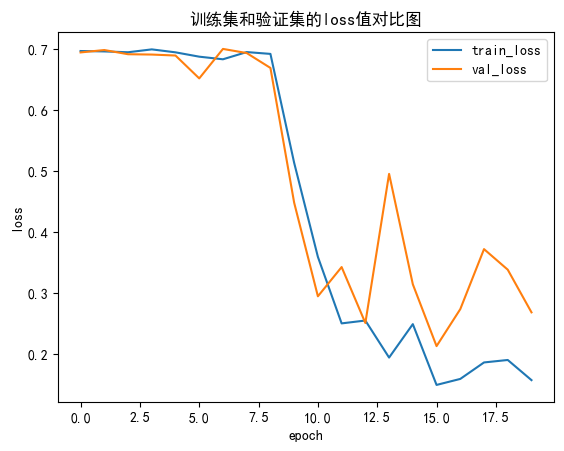

In [49]:
# 绘图loss
matplot_loss(loss_train, loss_val)

In [ ]:
# 绘图acc
matplot_acc(acc_train, acc_val)

## 6 运行推理

## 6.1 加载模型与权重

In [ ]:
# 如果有NVIDA显卡，可以转到GPU训练，否则用CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 加载训练好的模型和权重
model = MyAlexNet().to(device)  # 实例化模型
model.load_state_dict(torch.load('save_model/best_model.pth'))  # 加载最优模型权重
model.eval()  # 设置模型为评估模式（推理模式），关闭dropout和batch normalization等操作

## 6.2 加载图像并进行推理

In [ ]:
# 定义一个用于推理的transform，确保与训练时的transform一致
# 将图像的像素值归一化到[-1,1]之间
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    normalize
])

# 加载单张图像进行推理
def predict_image(image_path, model, transform):
    image = imread(image_path)  # 读取图像
    image = transform(image)  # 预处理图像
    image = image.unsqueeze(0)  # 添加一个维度，将图像转换为一个批次
    
    image = image.to(device)  # 将图像加载到设备（CPU或GPU）
    with torch.no_grad():  # 禁用梯度计算，加快推理速度
        output = model(image)  # 进行前向传播
        _, pred = torch.max(output, axis=1)  # 获取预测结果的最大值及其索引
        pred_label = crackInfo().names[pred.item()]  # 根据预测索引获取标签名称
    
    return pred_label  # 返回预测的标签

# 示例：推理单张图像
image_path = '1-CK.jpg'  # 替换为你要推理的图像路径
prediction = predict_image(image_path, model, infer_transform)
print(f"预测结果: {prediction}")